In [1]:
import pandas as pd
import numpy as np
import pdb 
from datetime import datetime, timedelta
from dis import dis
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

pd.options.mode.chained_assignment = None  # default='warn'

data = pd.read_csv("prepped_data.csv")

In [2]:
data_per_image = data.groupby(['origin']).mean()
data_per_image = data_per_image.sort_values(by=["score"])

# For malginant and benign images each
images = np.unique(data['origin'])

image_class = []
for i in images:
    tmp_label = data.loc[data['origin'] == i]['current_correct_answer'].iloc[0]
    image_class.append(tmp_label)
    
sort_by_image_id = data_per_image.sort_index()[:len(images)] #sort images by image name
sort_by_image_id['class'] = image_class

# retrieve melanoma and nevus images
melanoma = sort_by_image_id.loc[sort_by_image_id['class']=="['melanoma']"]
nevus = sort_by_image_id.loc[sort_by_image_id['class']=="['nevus']"]

#sort nevus descending and turn negative, melanoma ascending
melanoma.sort_values(by=["score"], inplace = True)
nevus.sort_values(by=["score"], ascending = False, inplace = True)
nevus  = nevus*-1
combined_images = nevus.append(melanoma)

In [5]:
malignancy = combined_images['score']
data['malignancy'] = np.nan

for i,n in enumerate(malignancy.index):
    data['malignancy'][data['origin']==n] = malignancy.values[i]   

In [6]:
similarity = data['malignancy'].shift(periods = 1) - data['malignancy'] #previous - current malignancy 
data['similarity_to_previous'] = similarity
data['similarity_bins'] = pd.cut(x=similarity, bins=np.arange(-200,210,10))
data_per_bin = data.groupby(['similarity_bins']).mean()

### 1-Back analysis before Merging two sides

In [7]:
import scipy.stats as stats

TP_1back = []
FP_1back = []
FN_1back = []
TN_1back = []
for start in np.arange(-200,210,10):
    data_temp = data[data['similarity_bins'] == pd.Interval(start, start + 10, closed='right')]
    TP = ((data_temp['chosen_answer'] == "['melanoma']") & (data_temp['current_correct_answer'] == "['melanoma']")).sum()
    FP = ((data_temp['chosen_answer'] == "['melanoma']") & (data_temp['current_correct_answer'] == "['nevus']")).sum()
    FN = ((data_temp['chosen_answer'] == "['nevus']") & (data_temp['current_correct_answer'] == "['melanoma']")).sum()
    TN = ((data_temp['chosen_answer'] == "['nevus']") & (data_temp['current_correct_answer'] == "['nevus']")).sum()
    
    TP_1back.append(TP)
    FP_1back.append(FP)
    FN_1back.append(FN)
    TN_1back.append(TN)

### 1-Back analysis after Merging two sides

<Figure size 432x288 with 0 Axes>

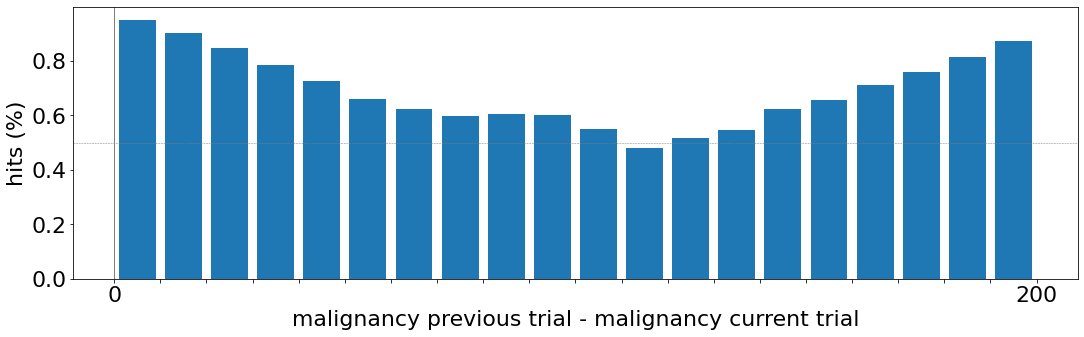

<Figure size 432x288 with 0 Axes>

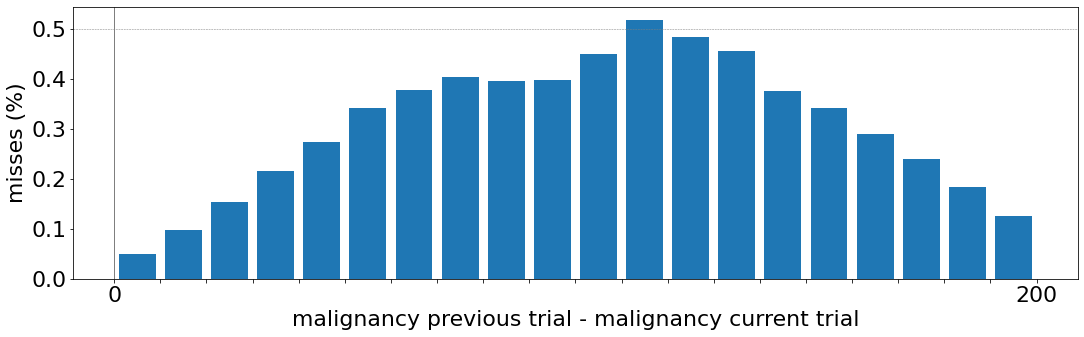

<Figure size 432x288 with 0 Axes>

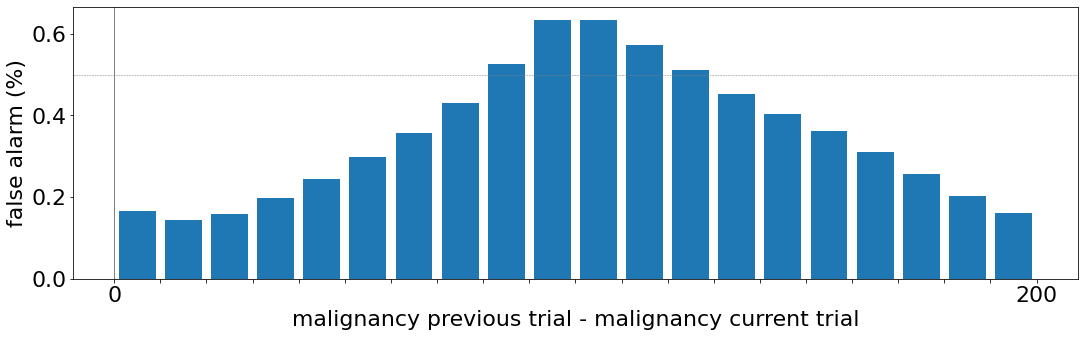

<Figure size 432x288 with 0 Axes>

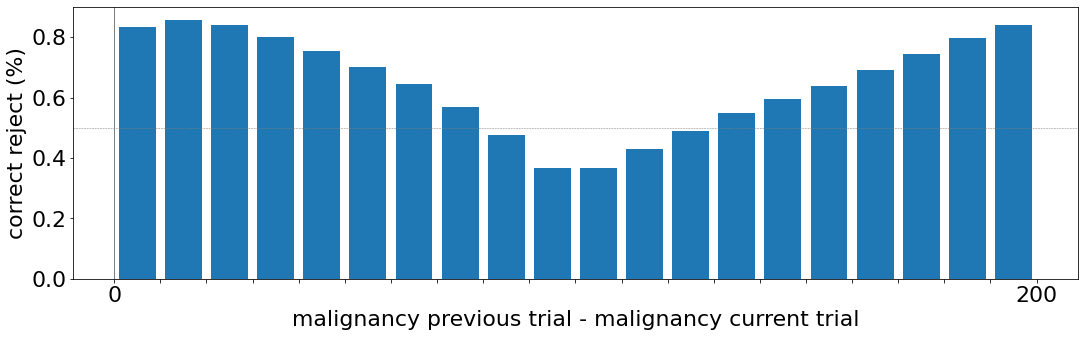

<Figure size 432x288 with 0 Axes>

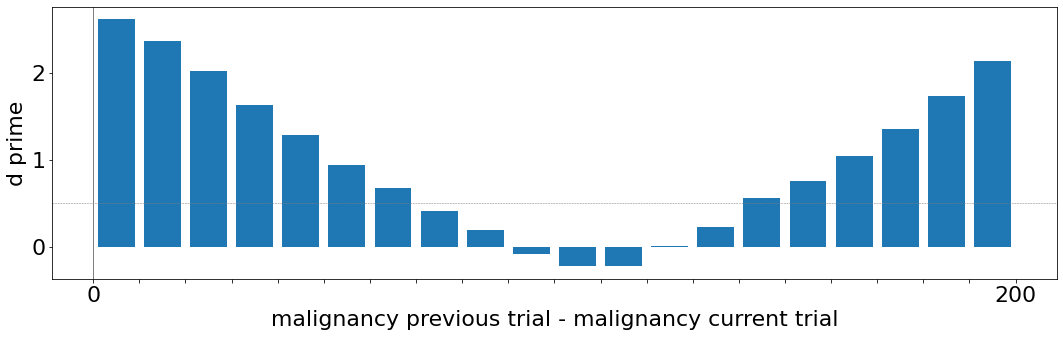

<Figure size 432x288 with 0 Axes>

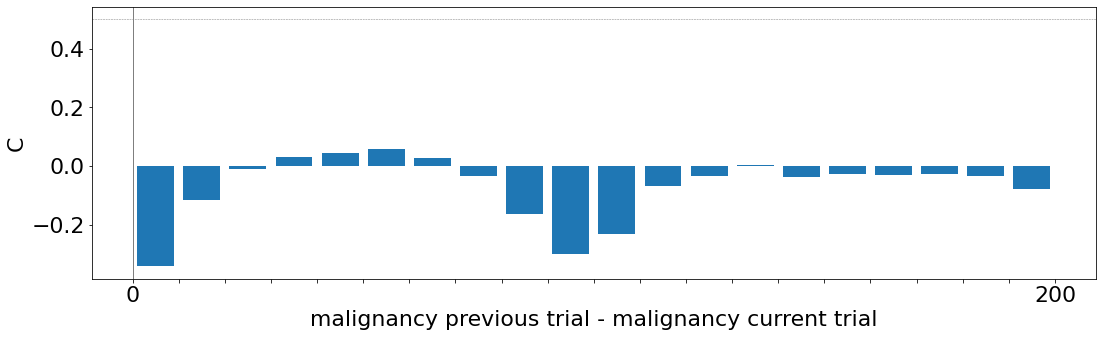

<Figure size 432x288 with 0 Axes>

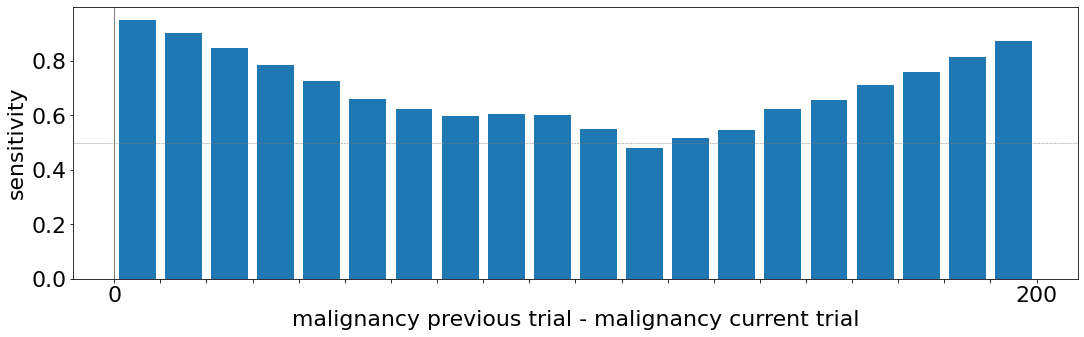

<Figure size 432x288 with 0 Axes>

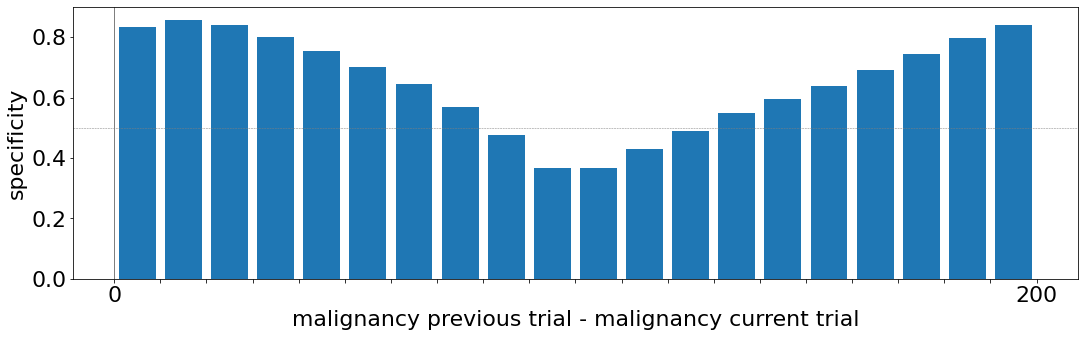

<Figure size 432x288 with 0 Axes>

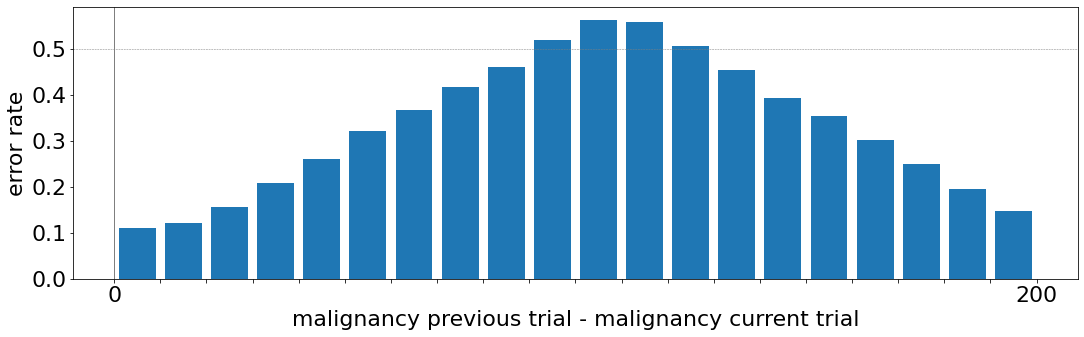

In [8]:
TP_1back_merge = np.zeros(20,)
FP_1back_merge = np.zeros(20,)
FN_1back_merge = np.zeros(20,)
TN_1back_merge = np.zeros(20,)

hit_1back_merge = np.zeros(20,)
miss_1back_merge = np.zeros(20,)
FA_1back_merge = np.zeros(20,)
CR_1back_merge = np.zeros(20,)

sensitivity_1back_merge = np.zeros(20,)
specificity_1back_merge = np.zeros(20,)
error_rate_1back_merge = np.zeros(20,)

for i in range(20):
    TP_1back_merge[i] = TP_1back[i] + TP_1back[39 - i]
    FP_1back_merge[i] = FP_1back[i] + FP_1back[39 - i]
    FN_1back_merge[i] = FN_1back[i] + FN_1back[39 - i]
    TN_1back_merge[i] = TN_1back[i] + TN_1back[39 - i]
    
    hit_1back_merge[i] = TP_1back_merge[i] / (TP_1back_merge[i] + FN_1back_merge[i])
    FA_1back_merge[i] = FP_1back_merge[i] / (FP_1back_merge[i] + TN_1back_merge[i])
    miss_1back_merge[i] = FN_1back_merge[i] / (FN_1back_merge[i] + TP_1back_merge[i])
    CR_1back_merge[i] = TN_1back_merge[i] / (TN_1back_merge[i] + FP_1back_merge[i])

    sensitivity_1back_merge[i] = TP_1back_merge[i] / (TP_1back_merge[i] + FN_1back_merge[i])
    specificity_1back_merge[i] = TN_1back_merge[i] / (TN_1back_merge[i] + FP_1back_merge[i])
    error_rate_1back_merge[i] = (FN_1back_merge[i] + FP_1back_merge[i]) / (TP_1back_merge[i] + FN_1back_merge[i] + FP_1back_merge[i] + TN_1back_merge[i])

# PLOT 1: hits
plt.figure()
y = hit_1back_merge
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('hits (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=0,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 2: miss
plt.figure()
y = miss_1back_merge
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('misses (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=0,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 3: false alarm
plt.figure()
y = FA_1back_merge
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('false alarm (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=0,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 4: correct reject
plt.figure()
y = CR_1back_merge
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('correct reject (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=0,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 5: d'
plt.figure()
y_1back_d = [stats.norm.ppf(a) - stats.norm.ppf(b) for (a,b) in zip(hit_1back_merge, FA_1back_merge)]
# y_1back_d = [0 if a != a else a for a in y_1back_d]
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y_1back_d)
plt.ylabel('d prime')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=0,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 6: C
plt.figure()
y_1back_c = [-(stats.norm.ppf(a) + stats.norm.ppf(b))/2 for (a,b) in zip(hit_1back_merge, FA_1back_merge)]
# y_1back_c = [0 if a != a else a for a in y_1back_c]
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y_1back_c)
plt.ylabel('C')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=0,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 7: sensitivity
plt.figure()
y_1back_sensitivity = sensitivity_1back_merge
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y_1back_sensitivity)
plt.ylabel('sensitivity')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=0,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 8: specificity
plt.figure()
y_1back_specificity = specificity_1back_merge
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y_1back_specificity)
plt.ylabel('specificity')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=0,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 9: error rate
plt.figure()
y_1back_error_rate = error_rate_1back_merge
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y_1back_error_rate)
plt.ylabel('error rate')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=0,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

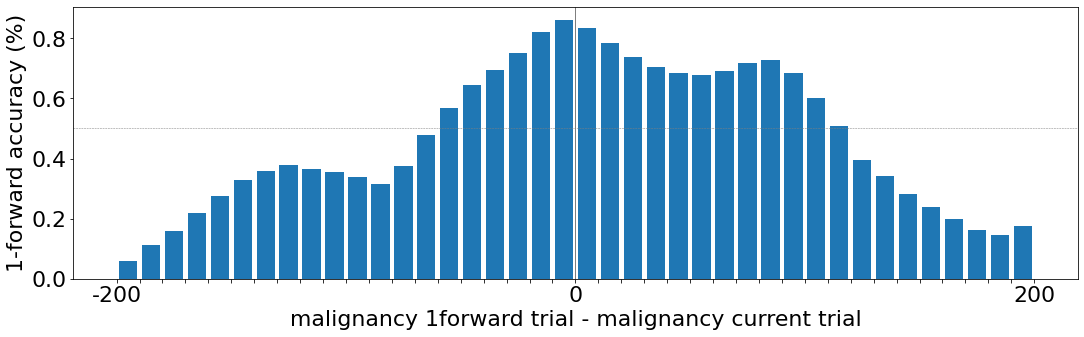

41


In [9]:
similarity_1forward = data['malignancy'].shift(periods = -1) - data['malignancy'] #previous - current malignancy 
data['similarity_to_1forward'] = similarity_1forward
data['similarity_1forward_bins'] = pd.cut(x=similarity_1forward, bins=np.arange(-200,210,10))
data_1forward_per_bin = data.groupby(['similarity_1forward_bins']).mean()

y = data_1forward_per_bin['1forward_accuracy']
x = data_1forward_per_bin.index
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = -200
x_labels[20] = 0
x_labels[40] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('1-forward accuracy (%)')
plt.xlabel('malignancy 1forward trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--') #

plt.show()
print(len(x_labels))

### 1-Forward analysis before Mergeing two sides

In [10]:
TP_1forward = []
FP_1forward = []
FN_1forward = []
TN_1forward = []
for start in np.arange(-200,210,10):
    data_temp = data[data['similarity_1forward_bins'] == pd.Interval(start, start + 10, closed='right')]
    TP = ((data_temp['chosen_answer'] == "['melanoma']") & (data_temp['current_correct_answer'] == "['melanoma']")).sum()
    FP = ((data_temp['chosen_answer'] == "['melanoma']") & (data_temp['current_correct_answer'] == "['nevus']")).sum()
    FN = ((data_temp['chosen_answer'] == "['nevus']") & (data_temp['current_correct_answer'] == "['melanoma']")).sum()
    TN = ((data_temp['chosen_answer'] == "['nevus']") & (data_temp['current_correct_answer'] == "['nevus']")).sum()
    
    TP_1forward.append(TP)
    FP_1forward.append(FP)
    FN_1forward.append(FN)
    TN_1forward.append(TN)

### 1-Forward analysis after Mergeing two sides

<Figure size 432x288 with 0 Axes>

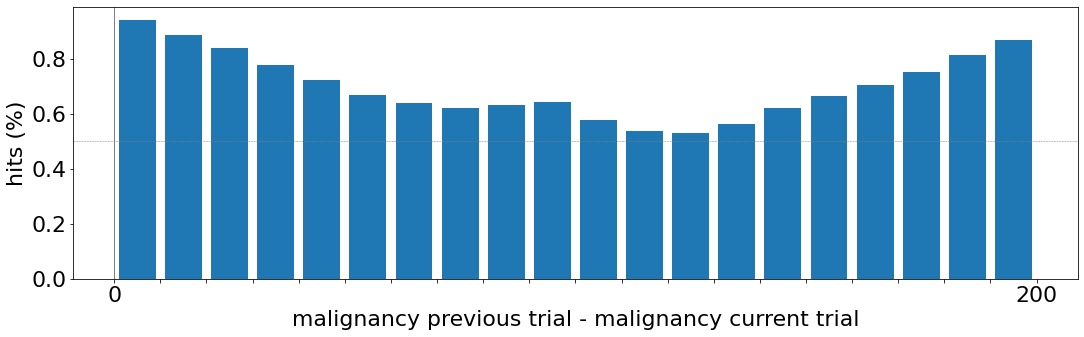

<Figure size 432x288 with 0 Axes>

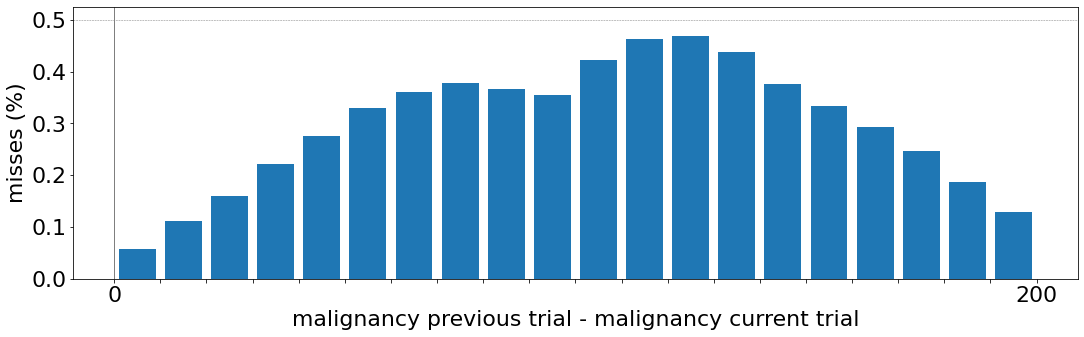

<Figure size 432x288 with 0 Axes>

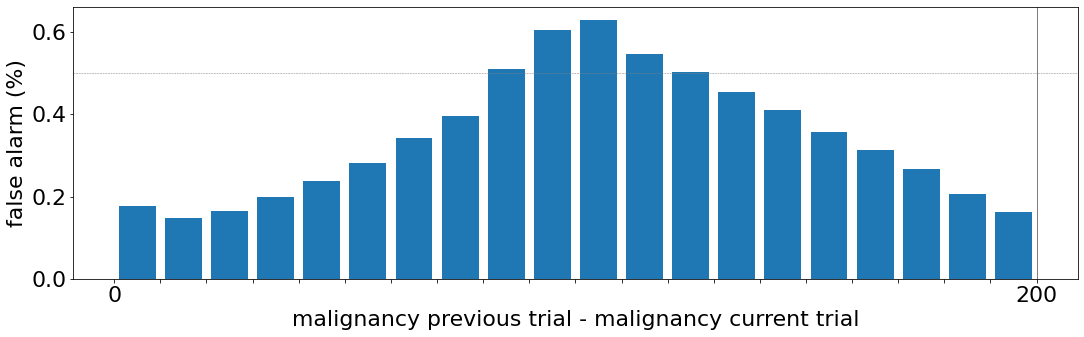

<Figure size 432x288 with 0 Axes>

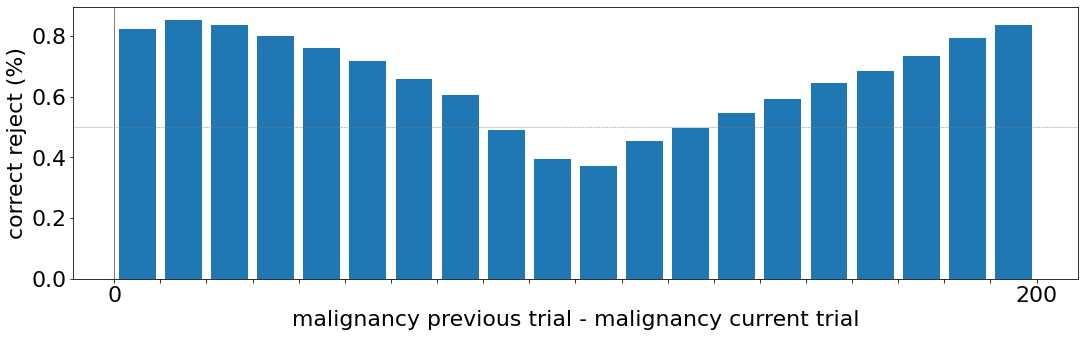

<Figure size 432x288 with 0 Axes>

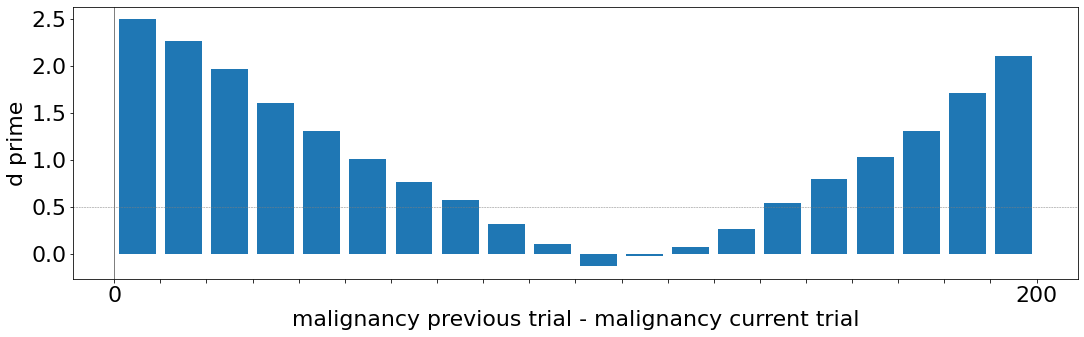

<Figure size 432x288 with 0 Axes>

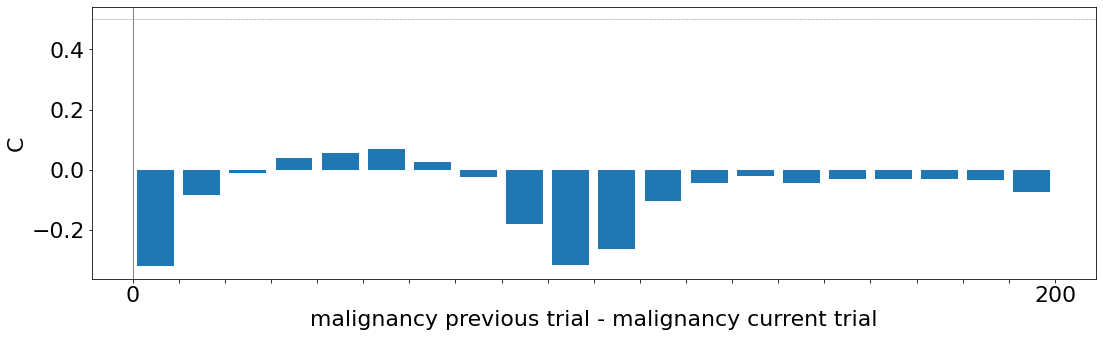

<Figure size 432x288 with 0 Axes>

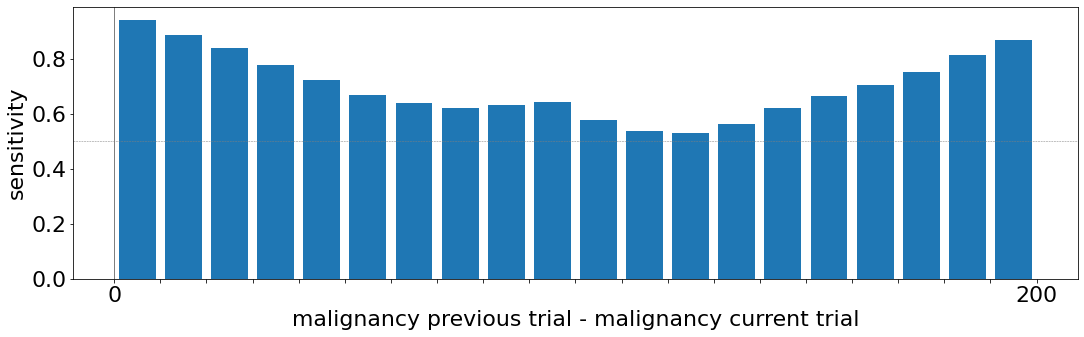

<Figure size 432x288 with 0 Axes>

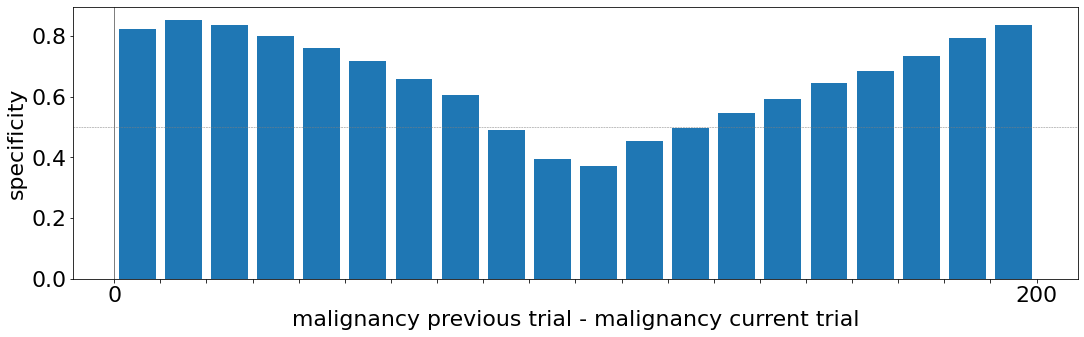

<Figure size 432x288 with 0 Axes>

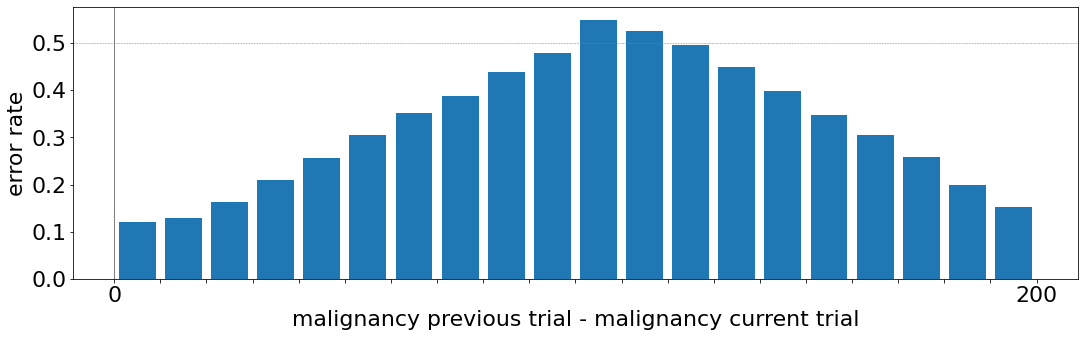

In [11]:
TP_1forward_merge = np.zeros(20,)
FP_1forward_merge = np.zeros(20,)
FN_1forward_merge = np.zeros(20,)
TN_1forward_merge = np.zeros(20,)

hit_1forward_merge = np.zeros(20,)
miss_1forward_merge = np.zeros(20,)
FA_1forward_merge = np.zeros(20,)
CR_1forward_merge = np.zeros(20,)

sensitivity_1forward_merge = np.zeros(20,)
specificity_1forward_merge = np.zeros(20,)
error_rate_1forward_merge = np.zeros(20,)

for i in range(20):
    TP_1forward_merge[i] = TP_1forward[i] + TP_1forward[39 - i]
    FP_1forward_merge[i] = FP_1forward[i] + FP_1forward[39 - i]
    FN_1forward_merge[i] = FN_1forward[i] + FN_1forward[39 - i]
    TN_1forward_merge[i] = TN_1forward[i] + TN_1forward[39 - i]
    
    hit_1forward_merge[i] = TP_1forward_merge[i] / (TP_1forward_merge[i] + FN_1forward_merge[i])
    FA_1forward_merge[i] = FP_1forward_merge[i] / (FP_1forward_merge[i] + TN_1forward_merge[i])
    miss_1forward_merge[i] = FN_1forward_merge[i] / (FN_1forward_merge[i] + TP_1forward_merge[i])
    CR_1forward_merge[i] = TN_1forward_merge[i] / (TN_1forward_merge[i] + FP_1forward_merge[i])

    sensitivity_1forward_merge[i] = TP_1forward_merge[i] / (TP_1forward_merge[i] + FN_1forward_merge[i])
    specificity_1forward_merge[i] = TN_1forward_merge[i] / (TN_1forward_merge[i] + FP_1forward_merge[i])
    error_rate_1forward_merge[i] = (FN_1forward_merge[i] + FP_1forward_merge[i]) / (TP_1forward_merge[i] + FN_1forward_merge[i] + FP_1forward_merge[i] + TN_1forward_merge[i])

# PLOT 1: hits
plt.figure()
y = hit_1forward_merge
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('hits (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=0,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 2: miss
plt.figure()
y = miss_1forward_merge
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('misses (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=0,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 3: false alarm
plt.figure()
y = FA_1forward_merge
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('false alarm (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 4: correct reject
plt.figure()
y = CR_1forward_merge
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('correct reject (%)')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=0,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 5: d'
plt.figure()
y_1forward_d = [stats.norm.ppf(a) - stats.norm.ppf(b) for (a,b) in zip(hit_1forward_merge, FA_1forward_merge)]
# y_1back_d = [0 if a != a else a for a in y_1back_d]
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y_1forward_d)
plt.ylabel('d prime')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=0,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 6: C
plt.figure()
y_1forward_c = [-(stats.norm.ppf(a) + stats.norm.ppf(b))/2 for (a,b) in zip(hit_1forward_merge, FA_1forward_merge)]
# y_1back_c = [0 if a != a else a for a in y_1back_c]
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y_1forward_c)
plt.ylabel('C')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=0,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 7: sensitivity
plt.figure()
y = sensitivity_1forward_merge
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('sensitivity')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=0,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 8: specificity
plt.figure()
y = specificity_1forward_merge
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('specificity')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=0,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

# PLOT 9: error rate
plt.figure()
y = error_rate_1forward_merge
x = data_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('error rate')
plt.xlabel('malignancy previous trial - malignancy current trial')
plt.axvline(x=0,linewidth=0.5, color='black')
plt.axhline(y=0.5,linewidth=0.5, color='grey', linestyle='--')

### Serial Dependence Analysis after merging

sum of hits:-0.1941353479753229
sum of miss:0.19413534797532325
sum of FA:0.11597408036683698
sum of CR:-0.11597408036683715
sum of sensitivity:-0.1941353479753229
sum of specificity:-0.11597408036683715
sum of error rate:0.14007261837354223


<Figure size 432x288 with 0 Axes>

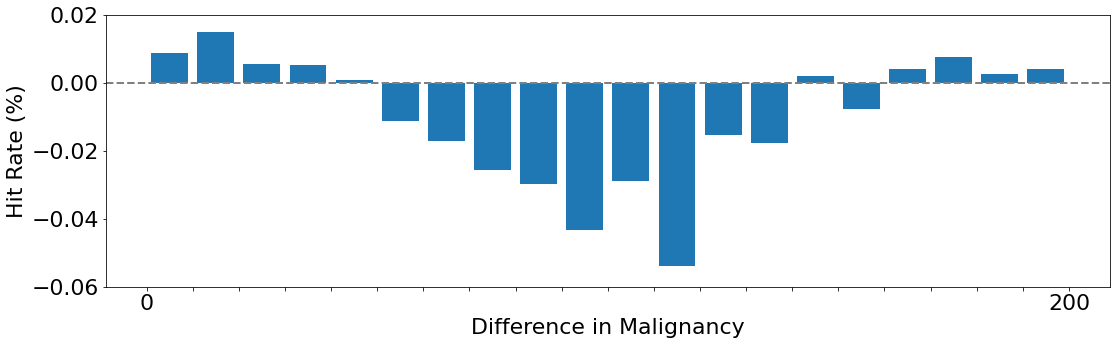

<Figure size 432x288 with 0 Axes>

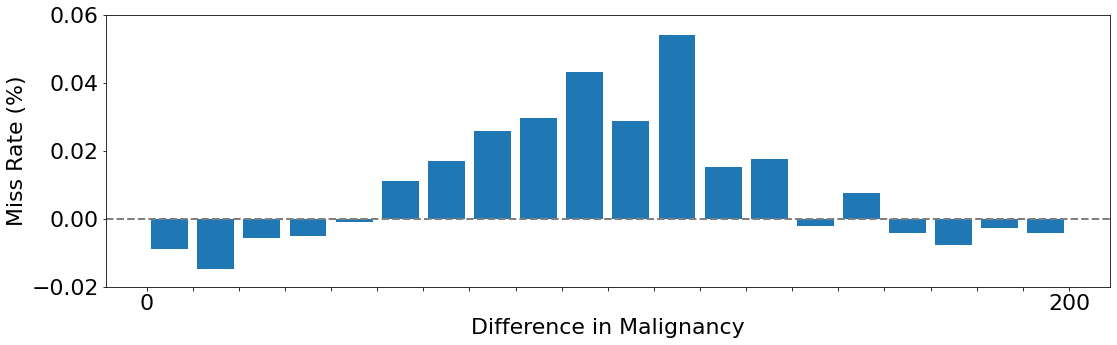

<Figure size 432x288 with 0 Axes>

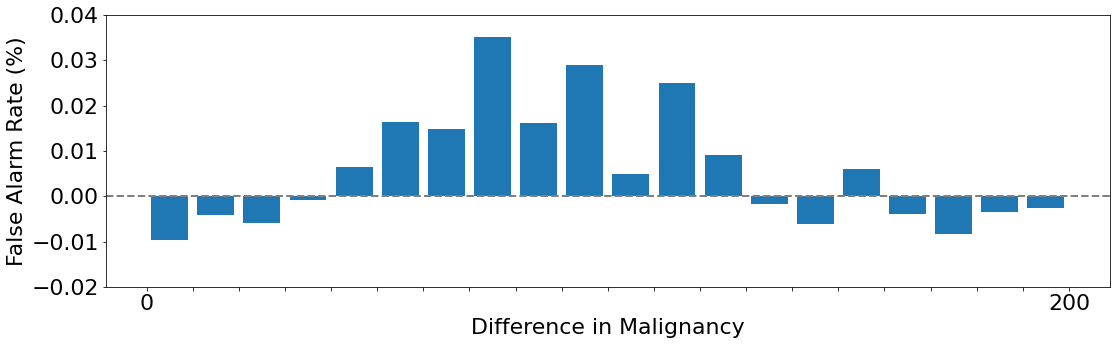

<Figure size 432x288 with 0 Axes>

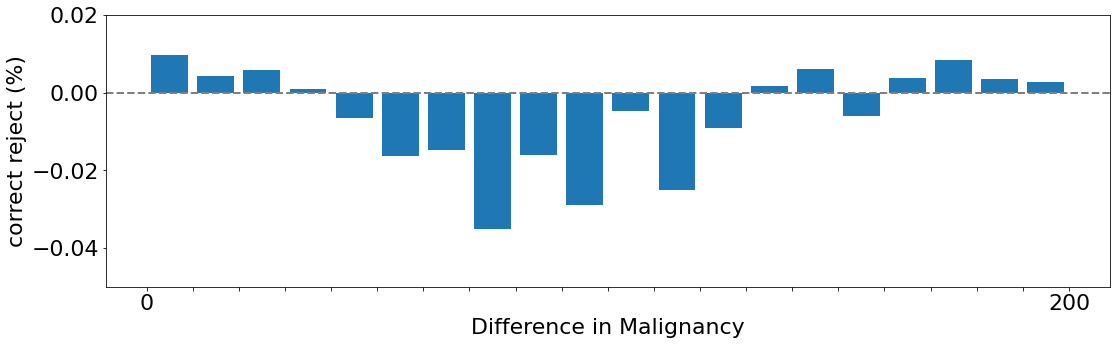

<Figure size 432x288 with 0 Axes>

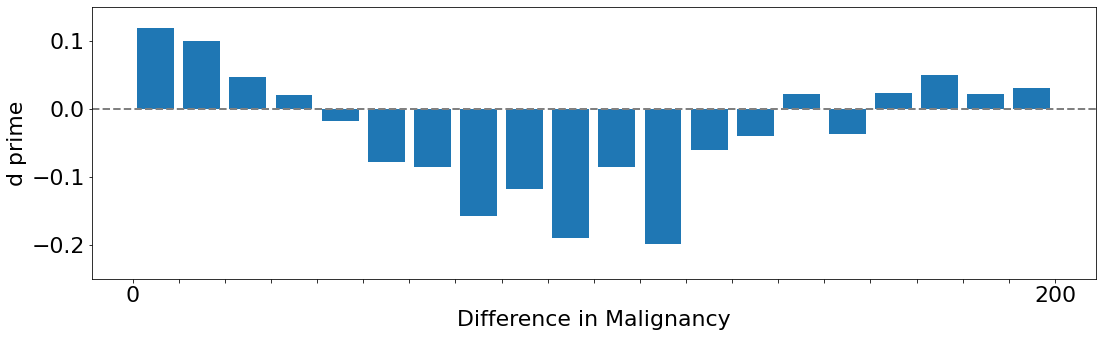

<Figure size 432x288 with 0 Axes>

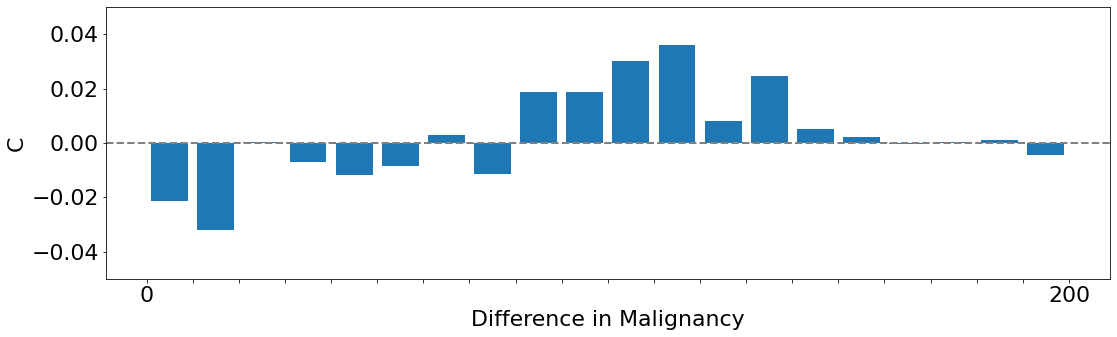

<Figure size 432x288 with 0 Axes>

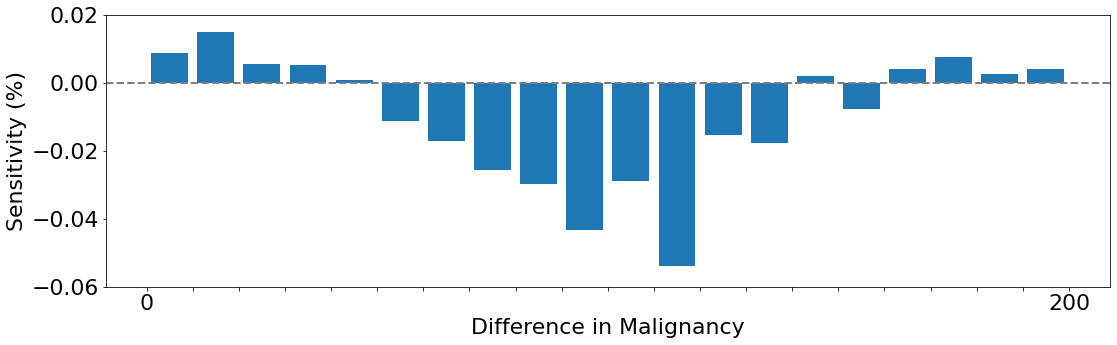

<Figure size 432x288 with 0 Axes>

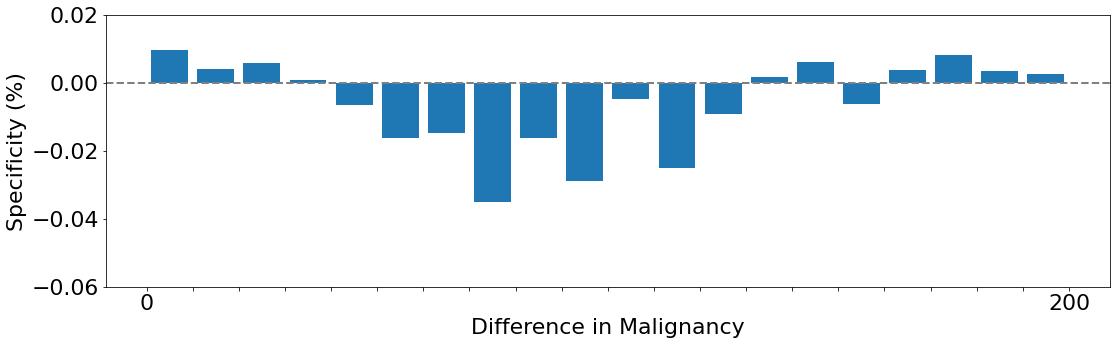

<Figure size 432x288 with 0 Axes>

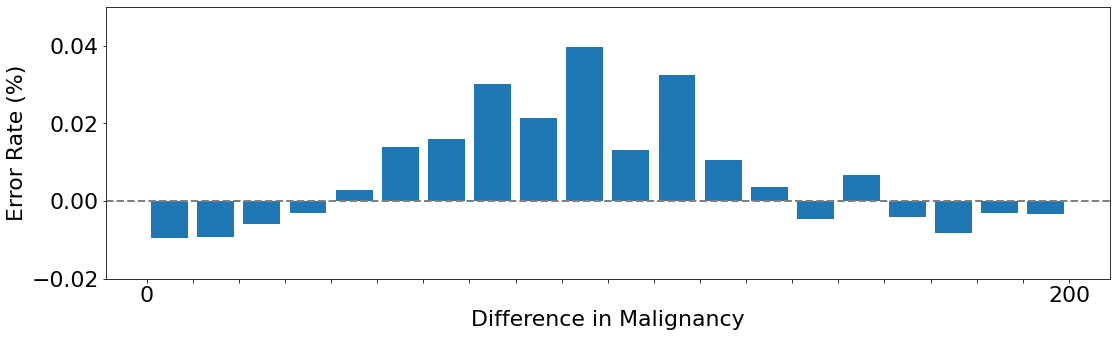

In [39]:
# PLOT 1: hits
plt.figure()
y = [a - b for (a,b) in zip(hit_1back_merge, hit_1forward_merge)]
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('Hit Rate (%)')
plt.xlabel('Difference in Malignancy')
#plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0,linewidth=2, color='grey', linestyle='--')
plt.ylim([-0.06, 0.02])
print('sum of hits:' + str(sum(y)))

# PLOT 2: miss
plt.figure()
y = [a - b for (a,b) in zip(miss_1back_merge, miss_1forward_merge)]
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('Miss Rate (%)')
plt.xlabel('Difference in Malignancy')
#plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0,linewidth=2, color='grey', linestyle='--')
plt.ylim([-0.02, 0.06])
print('sum of miss:' + str(sum(y)))

# PLOT 3: false alarm
plt.figure()
y = [a - b for (a,b) in zip(FA_1back_merge, FA_1forward_merge)]
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('False Alarm Rate (%)')
plt.xlabel('Difference in Malignancy')
#plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0,linewidth=2, color='grey', linestyle='--')
plt.ylim([-0.02, 0.04])
print('sum of FA:' + str(sum(y)))

# PLOT 4: correct reject
plt.figure()
y = [a - b for (a,b) in zip(CR_1back_merge, CR_1forward_merge)]
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('correct reject (%)')
plt.xlabel('Difference in Malignancy')
#plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0,linewidth=2, color='grey', linestyle='--')
plt.ylim([-0.05, 0.02])
print('sum of CR:' + str(sum(y)))

# PLOT 5: d'
plt.figure()
y = [a - b for (a,b) in zip(y_1back_d, y_1forward_d)]
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('d prime')
plt.xlabel('Difference in Malignancy')
#plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0,linewidth=2, color='grey', linestyle='--')
plt.ylim([-0.25, 0.15])


# PLOT 6: C
plt.figure()
y = [a - b for (a,b) in zip(y_1back_c, y_1forward_c)]
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('C')
plt.xlabel('Difference in Malignancy')
#plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0,linewidth=2, color='grey', linestyle='--')
plt.ylim([-0.05, 0.05])


# PLOT 7: sensitivity
plt.figure()
y = [a - b for (a,b) in zip(sensitivity_1back_merge, sensitivity_1forward_merge)]
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('Sensitivity (%)')
plt.xlabel('Difference in Malignancy')
#plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0,linewidth=2, color='grey', linestyle='--')
plt.ylim([-0.06, 0.02])
print('sum of sensitivity:' + str(sum(y)))

# PLOT 8: specificity
plt.figure()
y = [a - b for (a,b) in zip(specificity_1back_merge, specificity_1forward_merge)]
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('Specificity (%)')
plt.xlabel('Difference in Malignancy')
#plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0,linewidth=2, color='grey', linestyle='--')
plt.ylim([-0.06, 0.02])
print('sum of specificity:' + str(sum(y)))

# PLOT 9: error rate
plt.figure()
y = [a - b for (a,b) in zip(error_rate_1back_merge, error_rate_1forward_merge)]
x = data_1forward_per_bin.index[:20]
y_pos = np.arange(len(x)) + 0.5
plt.figure(figsize=(18, 5))
x_labels = ['']*(len(x)+1)
x_labels[0] = 0
x_labels[20] = 200
plt.xticks(np.arange(len(x)+1),x_labels)
plt.bar(y_pos, y)
plt.ylabel('Error Rate (%)')
plt.xlabel('Difference in Malignancy')
#plt.axvline(x=20,linewidth=0.5, color='black')
plt.axhline(y=0,linewidth=2, color='grey', linestyle='--')
plt.ylim([-0.02, 0.05])
print('sum of error rate:' + str(sum(y)))

In [47]:
temp1 = [1, 2, 3,4,5,6]
len(temp1)-2
temp1[4]

5

In [55]:
def running(arr):
    i = 2
    # Initialize an empty list to store cumulative moving
    # averages
    moving_averages = []

    # Store cumulative sums of array in cum_sum array
    cum_sum = np.cumsum(arr);

    item1 = (arr[0]+arr[1])/2
    moving_averages.append(item1)
    
    while i < len(arr):
        item = (arr[i-2] + arr[i-1] + arr[i])/3
        moving_averages.append(item)
        i += 1
    
    item2 = (arr[i-2]+arr[i-1])/2
    moving_averages.append(item2)
    return moving_averages

temp1 = [1,3,5,7,9]
running(temp1)

[2.0, 3.0, 5.0, 7.0, 8.0]